Based on:

@book{leborgne2022fraud,

title={Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook},

author={Le Borgne, Yann-A{\"e}l and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca},

url={https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook},

year={2022},

publisher={Universit{\'e} Libre de Bruxelles}

}

Covered subchapters:
* 6.2 Cost-sensitive learning
* 6.3 Resampling strategies

In [29]:
import datetime
import sklearn
import time
import pickle
import imblearn
import pandas as pd

In [16]:
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   192k      0 --:--:-- --:--:-- --:--:--  193k


<Figure size 640x480 with 0 Axes>

In [17]:
DIR_INPUT = '../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


n_folds = 4

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

Load  files
CPU times: total: 609 ms
Wall time: 612 ms
919767 transactions loaded, containing 8195 fraudulent transactions


#### Cost-sensitive learning

##### Decision tree

In [18]:
classifier = sklearn.tree.DecisionTreeClassifier()

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_dt = time.time()-start_time

In [19]:
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__class_weight'][0] for i in range(len(parameters_dict))]

performances_df_dt = performances_df

In [20]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.825500,0.009464,0.537440,0.033668,0.289286,0.010903,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",0.466999,0.837454,0.014356,0.532924,0.025252,0.277500,0.010944,0.01
1,0.792912,0.029734,0.561153,0.046031,0.273571,0.019418,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",0.463250,0.808213,0.022140,0.565880,0.027737,0.266071,0.013716,0.05
2,0.784486,0.031698,0.556320,0.031025,0.272143,0.019548,"{'clf__class_weight': {0: 0.1}, 'clf__max_dept...",0.458000,0.814153,0.023492,0.572758,0.029783,0.269643,0.015791,0.10
3,0.798043,0.020988,0.579394,0.016007,0.278214,0.003093,"{'clf__class_weight': {0: 0.5}, 'clf__max_dept...",0.454250,0.799682,0.013524,0.568408,0.018631,0.265000,0.013420,0.50
4,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__class_weight': {0: 1}, 'clf__max_depth'...",0.455000,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,1.00


In [21]:
summary_performances_dt = get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.01,0.1,0.01
Validation performance,0.837+/-0.01,0.573+/-0.03,0.278+/-0.01
Test performance,0.825+/-0.01,0.556+/-0.03,0.289+/-0.01
Optimal parameter(s),0.01,1.0,0.01
Optimal test performance,0.825+/-0.01,0.6+/-0.02,0.289+/-0.01


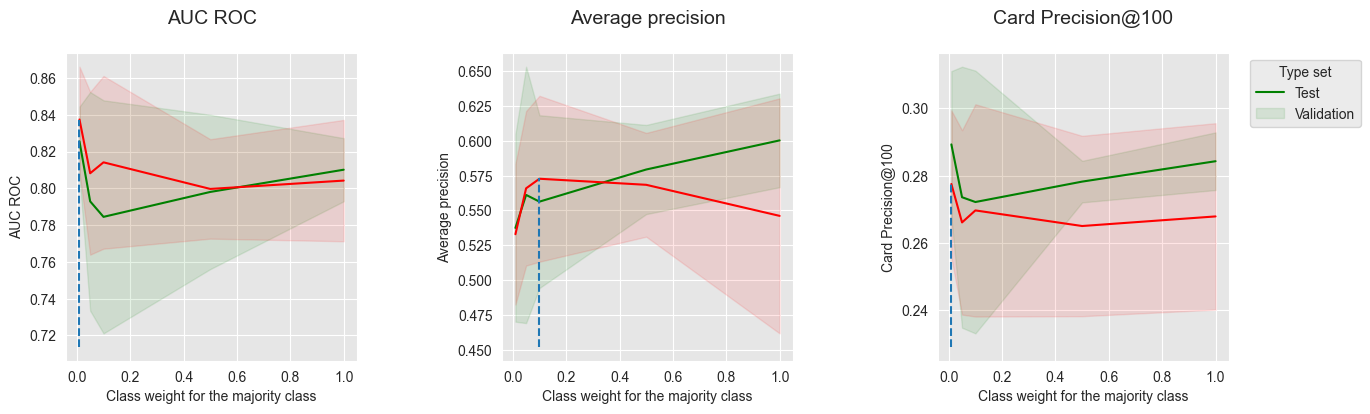

In [22]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight for the majority class",
                       summary_performances=summary_performances_dt)

In [24]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)
(train_df, test_df)=scaleData(train_df,test_df,input_features)

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, class_weight={0: 0.01}, random_state=0)
classifier.fit(train_df[input_features], train_df[output_feature])
pickle.dump(classifier, open('models/ML_imbalance_included/dt_maxdepth5_classweight0dot01_model.sav', 'wb'))

##### Logistic regression

In [10]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[1], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_lr = time.time()-start_time

In [11]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__class_weight'][0] for i in range(len(parameters_dict))]

performances_df_lr=performances_df

In [12]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.871396,0.017137,0.571129,0.028027,0.293929,0.010120,"{'clf__C': 1, 'clf__class_weight': {0: 0.01}, ...",0.292502,0.871069,0.009955,0.497808,0.039734,0.276429,0.013190,0.01
1,0.870711,0.016332,0.604805,0.015834,0.296786,0.009813,"{'clf__C': 1, 'clf__class_weight': {0: 0.05}, ...",0.313752,0.870584,0.008772,0.550617,0.029466,0.278571,0.015085,0.05
2,0.870083,0.016028,0.613923,0.014765,0.296429,0.008950,"{'clf__C': 1, 'clf__class_weight': {0: 0.1}, '...",0.312250,0.869906,0.008720,0.579392,0.019886,0.278214,0.014156,0.10
3,0.868234,0.015572,0.621852,0.015687,0.297500,0.008770,"{'clf__C': 1, 'clf__class_weight': {0: 0.5}, '...",0.321253,0.867853,0.008948,0.608950,0.023132,0.277143,0.015286,0.50
4,0.867643,0.015404,0.623081,0.016204,0.297143,0.008806,"{'clf__C': 1, 'clf__class_weight': {0: 1}, 'cl...",0.332751,0.866861,0.008988,0.612264,0.023474,0.278214,0.016914,1.00


In [13]:
summary_performances_lr = get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.01,1.0,0.05
Validation performance,0.871+/-0.01,0.612+/-0.02,0.279+/-0.02
Test performance,0.871+/-0.02,0.623+/-0.02,0.297+/-0.01
Optimal parameter(s),0.01,1.0,0.5
Optimal test performance,0.871+/-0.02,0.623+/-0.02,0.298+/-0.01


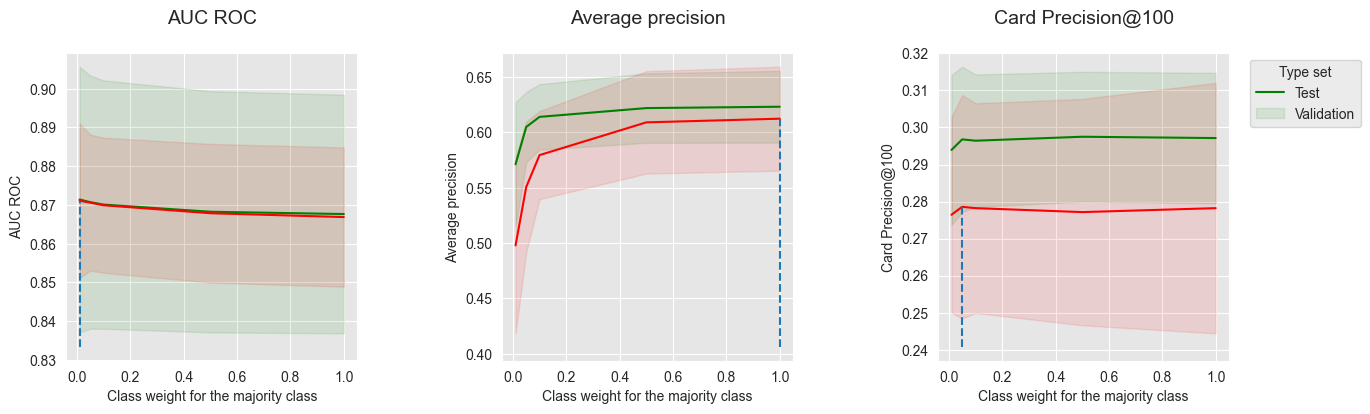

In [14]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Class weight for the majority class",
                       summary_performances=summary_performances_lr)

#### Resampling

In [26]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.01,0.1,0.01
Validation performance,0.837+/-0.01,0.573+/-0.03,0.278+/-0.01
Test performance,0.825+/-0.01,0.556+/-0.03,0.289+/-0.01
Optimal parameter(s),0.01,1.0,0.01
Optimal test performance,0.825+/-0.01,0.6+/-0.02,0.289+/-0.01


In [27]:
def prequential_grid_search_with_sampler(transactions_df, 
                                         classifier, sampler_list,
                                         input_features, output_feature, 
                                         parameters, scoring, 
                                         start_date_training, 
                                         n_folds=4,
                                         expe_type='Test',
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):
    
    estimators = sampler_list.copy()
    estimators.extend([('clf', classifier)])
    
    pipe = imblearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices = prequentialSplit(transactions_df,
                                                 start_date_training=start_date_training, 
                                                 n_folds=n_folds, 
                                                 delta_train=delta_train, 
                                                 delta_delay=delta_delay, 
                                                 delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X = transactions_df[input_features]
    y = transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df = pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters'] = grid_search.cv_results_['params']
    performances_df['Execution time'] = grid_search.cv_results_['mean_fit_time']
    
    return performances_df

In [28]:
def model_selection_wrapper_with_sampler(transactions_df, 
                                         classifier, 
                                         sampler_list,
                                         input_features, output_feature,
                                         parameters, 
                                         scoring, 
                                         start_date_training_for_valid,
                                         start_date_training_for_test,
                                         n_folds=4,
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):

    performances_df_validation = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    performances_df_test = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df = pd.concat([performances_df_test,performances_df_validation],axis=1)

    return performances_df

##### SMOTE Oversampling

In [30]:
classifier = sklearn.tree.DecisionTreeClassifier()

sampler_list = [('sampler', imblearn.over_sampling.SMOTE(random_state=0))]

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_SMOTE = time.time()-start_time

In [31]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_SMOTE = performances_df

In [32]:
summary_performances_SMOTE = get_summary_performances(performances_df_SMOTE, parameter_column_name="Parameters summary")
summary_performances_SMOTE

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1.0,0.05,0.5
Validation performance,0.857+/-0.01,0.558+/-0.03,0.279+/-0.02
Test performance,0.845+/-0.01,0.573+/-0.02,0.289+/-0.02
Optimal parameter(s),1.0,0.01,1.0
Optimal test performance,0.845+/-0.01,0.587+/-0.01,0.295+/-0.01


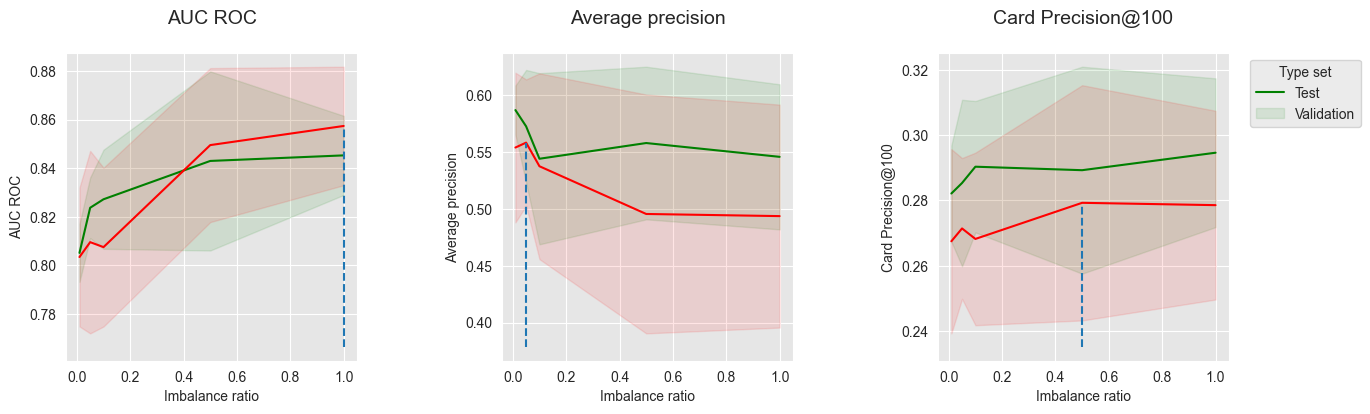

In [33]:
get_performances_plots(performances_df_SMOTE, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_SMOTE)

In [45]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

smote = imblearn.over_sampling.SMOTE(sampling_strategy=1, random_state=0)
train_df_input_resampled, train_df_output_resampled = smote.fit_resample(train_df[input_features], train_df[output_feature])
train_df = pd.concat([train_df_input_resampled, train_df_output_resampled], axis=1)

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)
classifier.fit(train_df[input_features], train_df[output_feature])
pickle.dump(classifier, open('models/ML_imbalance_included/dt_maxdepth5_smote1_model.sav', 'wb'))

##### Random Undersampling

In [34]:
classifier = sklearn.tree.DecisionTreeClassifier()

sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_RUS = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_RUS = performances_df

In [35]:
summary_performances_RUS=get_summary_performances(performances_df_RUS, parameter_column_name="Parameters summary")
summary_performances_RUS

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1.0,0.01,0.1
Validation performance,0.845+/-0.01,0.535+/-0.04,0.269+/-0.01
Test performance,0.83+/-0.01,0.594+/-0.02,0.277+/-0.01
Optimal parameter(s),1.0,0.01,0.5
Optimal test performance,0.83+/-0.01,0.594+/-0.02,0.292+/-0.01


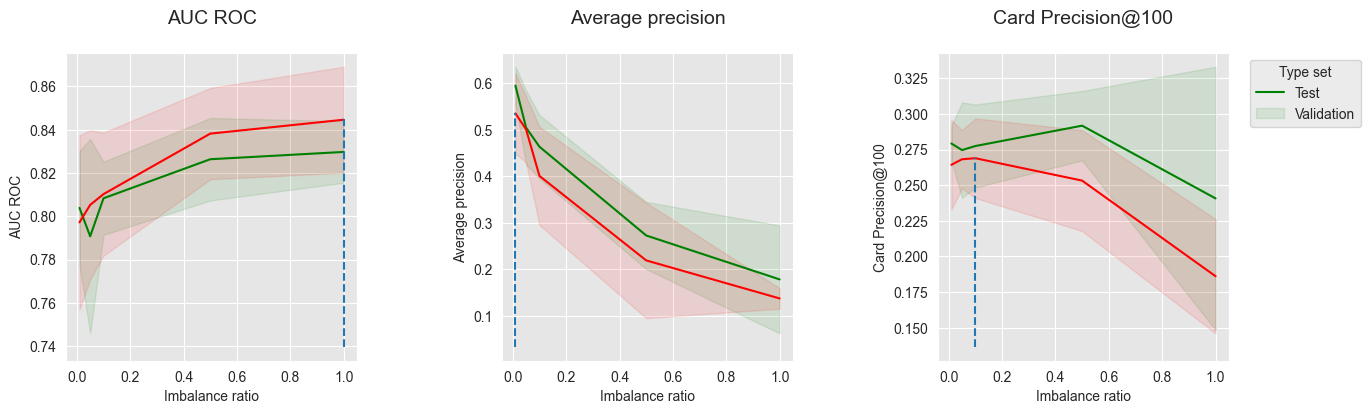

In [36]:
get_performances_plots(performances_df_RUS, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_RUS)

##### Combining SMOTE and Random Undersampling

In [37]:
classifier = sklearn.tree.DecisionTreeClassifier()

sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())
               ]

parameters = {'clf__max_depth':[5], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.1], 
              'sampler2__sampling_strategy':[0.1, 0.5, 1], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

performances_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_combined = time.time()-start_time

parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler2__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_combined = performances_df

In [38]:
performances_df_combined

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.827219,0.010190,0.544275,0.037686,0.290357,0.010070,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.559000,0.807543,0.016324,0.537672,0.040918,0.268214,0.013224,0.1
1,0.848464,0.008701,0.471467,0.010144,0.299643,0.011968,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.335750,0.841237,0.015297,0.428576,0.050091,0.279286,0.010903,0.5
2,0.847110,0.010754,0.385133,0.064916,0.287857,0.018364,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.329749,0.856399,0.012189,0.342964,0.020342,0.280357,0.017420,1.0


In [39]:
summary_performances_combined = get_summary_performances(performances_df=performances_df_combined, 
                                                         parameter_column_name="Parameters summary")
summary_performances_combined

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1.0,0.1,1.0
Validation performance,0.856+/-0.01,0.538+/-0.04,0.28+/-0.02
Test performance,0.847+/-0.01,0.544+/-0.04,0.288+/-0.02
Optimal parameter(s),0.5,0.1,0.5
Optimal test performance,0.848+/-0.01,0.544+/-0.04,0.3+/-0.01


In [46]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state=0)
train_df_input_resampled, train_df_output_resampled = smote.fit_resample(train_df[input_features], train_df[output_feature])
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state=0)
train_df_input_resampled, train_df_output_resampled = rus.fit_resample(train_df_input_resampled, train_df_output_resampled)
train_df = pd.concat([train_df_input_resampled, train_df_output_resampled], axis=1)

classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5, random_state=0)
classifier.fit(train_df[input_features], train_df[output_feature])
pickle.dump(classifier, open('models/ML_imbalance_included/dt_maxdepth5_smote0dot1_randundersampl1_model.sav', 'wb'))

##### Comparison

In [40]:
summary_test_performances = pd.concat([summary_performances_dt.iloc[2,:],
                                       summary_performances_SMOTE.iloc[2,:],
                                       summary_performances_RUS.iloc[2,:],
                                       summary_performances_combined.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline', 'SMOTE', 'RUS', 'Combined']
summary_test_performances

,Baseline,SMOTE,RUS,Combined
AUC ROC,0.825+/-0.01,0.845+/-0.01,0.83+/-0.01,0.847+/-0.01
Average precision,0.556+/-0.03,0.573+/-0.02,0.594+/-0.02,0.544+/-0.04
Card Precision@100,0.289+/-0.01,0.289+/-0.02,0.277+/-0.01,0.288+/-0.02
